# computational check for LR model
Tim Tyree<br>
6.22.2022

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from numba import njit
#load the libraries
from lib import *

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
from lib.my_initialization import *
%autocall 1
%load_ext autoreload
%autoreload 2
# awareness&chill

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#reset matplotlib
import matplotlib as mpl
# import seaborn as sns
# sns.reset_orig()
mpl.rc_file_defaults()
import matplotlib.ticker as mtick

Q: am I using the same initial conditions as WJ?

`c init. conditions
      open(unit=40,file='init_cond_rest',status='unknown')
      read(40,*)u,ca,x1,xm,xh,xj,xd,xf`


`
cat init_cond_rest  
  -84.660321188012958        1.4545256072491180E-007   5.5810241673725797E-003   1.6354133541151676E-003  0.98371668922815847       0.98977009269126759        2.9491168042779553E-003  0.99998163447373467  
`

`      write(10,*)u,ca,x1,xm,xh,xj,xd,xf`

# define module

In [6]:
# @njit
# def I_stim(I_magnitude=10,t_duration=5.):
#     return I_magnitude

def get_mycomp_ionic_flux(GNa=16.,#matches wj
                          GK1=0.6047, #not used
                          Gsi=0.052,#matches wj
                          EK1=-87.94,#not used
                          Eb=-59.87,#not used
                          ENa=54.4,#matches wj
                          **kwargs):#,GK=0.423
    # #maximum conductances
    # GNa = 16.     #mS/cm^2 from Qu2000.pdf #GNa=23 in Luo1990.pdf
    # GK1 = 0.6047  #mS/cm^2 from Qu2000.pdf
    # Gsi = 0.052   #mS/cm^2 spiral wave breakup phase from Qu2000.pdf
    # GK  = 0.423   #mS/cm^2 #from Qu2000.pdf
    # #reversal potentials
    # EK1 = -87.94 #mV
    # EKp = EK1    #mV
    # Eb  = -59.87 #mV
    # ENa = 54.4   #mV

    @njit
    def comp_ionic_flux(V,inCgate,IK1T,x1,Ca_i):
        """returns updated  gating variables"""
        m = inCgate[0] #activation gate parameter (Na)
        h = inCgate[1] #fast inactivation gate parameter (INa)
        j = inCgate[2] #slow inactivation gate parameter (INa)
        d = inCgate[3] #activation gate parameter (Isi)
        f = inCgate[4] #inactivation gate parameter (Isi)
        x_var = inCgate[5] #activation gate parameter (IK)
        #Fast sodium current
        INa = GNa*m**3*h*j*(V-ENa)
        #Slow inward current
        # Esi=7.7-13.0287*np.log(Ca_i)#mV  #from Luo1990.pdf
        Esi=-82.3-13.0287*np.log(Ca_i)#mV  #from lr_d0.f (WJ)
        Isi=Gsi*d*f*(V-Esi)
        #time dependent potassium current 
        IK=x_var*x1#GK*x_var*x1#
        ##total electric current
        #Iion=INa+IK1T+Isi+IK
        #calcium uptake rate (dominated by activity of the sarcoplasmic reticulum)
        # dCa_i_dt=-10**-4*Isi+0.07*(10**-4-Ca_i) #mM #from Luo1990.pdf
        dCa_i_dt=-10**-7 * Isi + 0.07*(10**-7 - Ca_i)   #M  #from lr_d0.f (WJ)
        return INa,IK1T,Isi,IK, dCa_i_dt
    return comp_ionic_flux

__goto__ - 'Luo-Rudy Model.ipynb' and see chapter `Action potentials from the LR model in 0D` for a computational check _versus_ the result of ./lib/model/comp_check_LR/run_test_LR.sh _with respect to_ voltage as a function of time.

# Generate reference data from fortranic implementation

In [5]:
os.chdir(f'{nb_dir}/lib/model/comp_check_LR')
!./run_test_LR.sh



You have not agreed to the Xcode license agreements. You must agree to both license agreements below in order to use Xcode.

Press the 'return' key to view the license agreements at '/Applications/Xcode.app/Contents/Resources/en.lproj/License.rtf'
^C


# Generate my data (Simulation of 1-3 externally stimulated 0D action potentials from the Luo-Rudy model using the lookup table generated by `gener_table.py` in lib.model)

In [171]:
# # this is the original version that resulted from my first computational check task with LR against WJ's fortranic onestep method.
# # #initialize system using resting state from WJ
# dt=0.1 #ms
# V   = -84.660321188012958
# Ca_i= 1.4545256072491180E-007

# x_var   =  5.5810241673725797E-003
# m   =  1.6354133541151676E-003
# h   =  0.98371668922815847
# j   =  0.98977009269126759
# d   =  2.9491168042779553E-003
# f   =  0.99998163447373467

# inCgate=np.array([m,h,j,d,f,x_var])
# outCgate=inCgate.copy()
# #initialize methods
# Cm=1. # µF/cm^2 membrane capacitance determined by gap junctions between myocardial cells
# #precompute lookup table
# arr39=get_arr39(dt,nb_dir)
# v_values=arr39[:,0]
# lookup_params=get_lookup_params(v_values,dv=0.1)
# mycomp_ionic_flux=get_mycomp_ionic_flux()
# #[V,Ca_i,m,h,j,d,f,x_var]

# tf = 500#ONE_SPIKE
# # tf =2000#up to 2 seconds
# count=0.
# dur=5.
# mag=-10.#
# #       xstim=10.
# #       tstim=5.
# #       nstim=nint(tstim/dt)
# # forward integrate to tf
# num_time_steps=int(tf/dt)
# t_values=np.array([j*dt for j in range(num_time_steps)])

# #forward euler integrate V to time t, saving all dynamic values
# V_lst = [];m_lst=[];h_lst=[];j_lst=[];d_lst=[];f_lst=[];x_var_lst=[];Ca_i_lst=[]
# IK_lst=[];INa_lst=[];ICa_lst=[];Istim_lst=[];Iion_lst=[]
# t=0
# # for step in range(num_time_steps):
# #     t+=dt
# t_values=np.arange(dt,500+dt,dt)
# # t_values+=dt #to match wj's implementation
# for t in t_values:
#     #compute currents
#     arr_interp=lookup_params(V,arr39)
#     x_infty,tau_x,m_infty,tau_m,h_infty,tau_h,j_infty,tau_j,d_infty,tau_d,f_infty,tau_f,IK1T,x1,e1,em,eh,ej,ed,ef=arr_interp[1:]
#     INa,IK1T,Isi,IK,dCa_i_dt=mycomp_ionic_flux(V,inCgate,IK1T,x1,Ca_i)
#     Iion=INa+IK1T+Isi+IK
#     #compute external stimulus
#     if ((t>0.) & (t<=0.+dur))|((t>500.) & (t<=500.+dur))|((t>1000.) & (t<=1000.+dur)):
#     #     if ((t>0.) & (t<0.+dur)):#ONE_SPIKE
#         Istim=mag
#     else:
#         Istim=0.
    
#     #record time and variables
#     m,h,j,d,f,x_var=inCgate.T
#     V_lst.append(V);m_lst.append(m);h_lst.append(h);j_lst.append(j);d_lst.append(d);f_lst.append(f);x_var_lst.append(x_var);Ca_i_lst.append(Ca_i)
#     Istim_lst.append(Istim);IK_lst.append(IK+IK1T);ICa_lst.append(Isi);INa_lst.append(INa);Iion_lst.append(Iion)
    
#     #integrate variables
#     comp_exact_next_gating_var(inCgate, outCgate, arr_interp)
#     inCgate=outCgate.copy()
#     dVdt=-(Iion+Istim)/Cm
#     V += dt*dVdt
#     Ca_i+=dt*dCa_i_dt
#     #update time
#     #     t+=dt
#     count+=1
# #     printProgressBar(count,num_time_steps)
# V_values=np.array(V_lst)
# #gating values
# m_values=np.array(m_lst)
# h_values=np.array(h_lst)
# j_values=np.array(j_lst)
# d_values=np.array(d_lst)
# f_values=np.array(f_lst)
# x_var_values=np.array(x_var_lst)
# Ca_i_values=np.array(Ca_i_lst)
# #current values
# IK_values=np.array(IK_lst)
# ICa_values=np.array(ICa_lst)
# INa_values=np.array(INa_lst)
# Istim_values=np.array(Istim_lst)
# Iion_values=np.array(Iion_lst)
# beep(1)

-n 


0

In [185]:
get_arr39

<function lib.model.LR_model_optimized.get_arr39(dt, nb_dir)>

In [187]:
# #initialize system using resting state from WJ
V   = -84.660321188012958
Ca_i= 1.4545256072491180E-007
#heretim
x_var   =  5.5810241673725797E-003
m   =  1.6354133541151676E-003
h   =  0.98371668922815847
j   =  0.98977009269126759
d   =  2.9491168042779553E-003
f   =  0.99998163447373467

tf = 500 #ms
dt=0.1   #ms
count=0.
dur=5.
mag=-10
Cm=1. # µF/cm^2 membrane capacitance determined by gap junctions between myocardial cells
saving=True


inCgate=np.array([m,h,j,d,f,x_var])
outCgate=inCgate.copy()
#initialize methods
#precompute lookup table
arr39=get_arr39(dt,nb_dir)
v_values=arr39[:,0]
lookup_params=get_lookup_params(v_values,dv=0.1)
mycomp_ionic_flux=get_mycomp_ionic_flux()
#[V,Ca_i,m,h,j,d,f,x_var]


# forward integrate to tf
num_time_steps=int(tf/dt)

#forward euler integrate V to time t, saving all dynamic values
V_lst = [];m_lst=[];h_lst=[];j_lst=[];d_lst=[];f_lst=[];x_var_lst=[];Ca_i_lst=[]
IK_lst=[];INa_lst=[];ICa_lst=[];Istim_lst=[];Iion_lst=[]
# for step in range(num_time_steps):
#     t+=dt
# t_values=np.array([j*dt for j in range(num_time_steps)])
# t_values+=dt #to match wj's implementation
t_values=np.arange(dt,500+dt,dt) #to match wj's implementation
for t in t_values:
    #compute currents
    arr_interp=lookup_params(V,arr39) #waarden
    x_infty,tau_x,m_infty,tau_m,h_infty,tau_h,j_infty,tau_j,d_infty,tau_d,f_infty,tau_f,IK1T,x1,e1,em,eh,ej,ed,ef=arr_interp[1:]
    INa,IK1T,Isi,IK,dCa_i_dt=mycomp_ionic_flux(V,inCgate,IK1T,x1,Ca_i)
    Iion=INa+IK1T+Isi+IK
    #compute external stimulus
    if ((t>0.) & (t<=0.+dur))|((t>500.) & (t<=500.+dur))|((t>1000.) & (t<=1000.+dur)):
    #     if ((t>0.) & (t<0.+dur)):#ONE_SPIKE
        Istim=mag
    else:
        Istim=0.
    
    #record time and variables
    m,h,j,d,f,x_var=inCgate.T
    V_lst.append(V);m_lst.append(m);h_lst.append(h);j_lst.append(j);d_lst.append(d);f_lst.append(f);x_var_lst.append(x_var);Ca_i_lst.append(Ca_i)
    Istim_lst.append(Istim);IK_lst.append(IK+IK1T);ICa_lst.append(Isi);INa_lst.append(INa);Iion_lst.append(Iion)
    
    #integrate variables
    comp_exact_next_gating_var(inCgate, outCgate, arr_interp)
    inCgate=outCgate.copy()
    dVdt=-(Iion+Istim)/Cm
    V += dt*dVdt
    Ca_i+=dt*dCa_i_dt
    #update time
    #     t+=dt
    count+=1
#     printProgressBar(count,num_time_steps)
V_values=np.array(V_lst)
#gating values
m_values=np.array(m_lst)
h_values=np.array(h_lst)
j_values=np.array(j_lst)
d_values=np.array(d_lst)
f_values=np.array(f_lst)
x_var_values=np.array(x_var_lst)
Ca_i_values=np.array(Ca_i_lst)
#current values
IK_values=np.array(IK_lst)
ICa_values=np.array(ICa_lst)
INa_values=np.array(INa_lst)
Istim_values=np.array(Istim_lst)
Iion_values=np.array(Iion_lst)
beep(1)

-n 


0

In [188]:
df=pd.DataFrame({
    't':t_values,
    'V':V_values,
    'Ca_i':Ca_i_values,
    'INa':INa_values,
    'IK' :IK_values,
    'ICa':ICa_values,
    'Istim':Istim_values,
    'm':m_values,
    'h':h_values,
    'j':j_values,
    'd':d_values,
    'f':f_values,
    'x_var':x_var_values,
})

if saving:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    df.to_csv(f'LR_action_potentials_optimized_tf_{tf}.csv')
    os.path.abspath(f'LR_action_potentials_optimized_tf_{tf}.csv')

# DONE: quantify the disagreement between the two one step methods

In [189]:
#load results from earlier
os.chdir(os.path.join(nb_dir,'Figures/methods'))
# df=pd.read_csv('LR_action_potentials_optimized.csv')
df=pd.read_csv('LR_action_potentials_optimized_tf_500.csv')

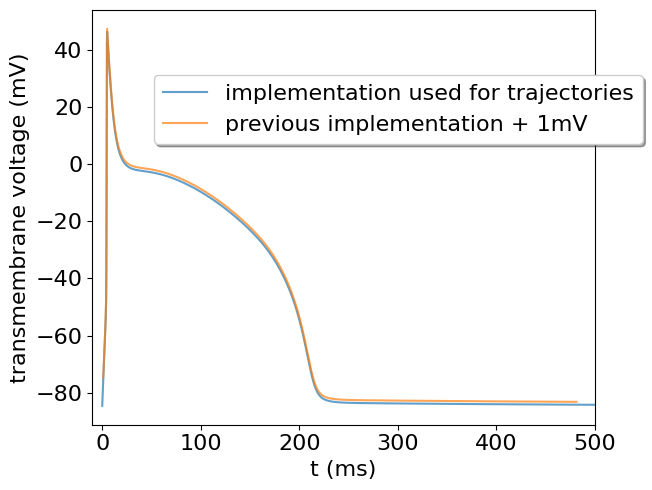

In [194]:
#load WJ's results
os.chdir(os.path.join(nb_dir,'lib/model/comp_check_LR'))
wj=np.loadtxt('fort.1')
col1,col1,col3,col4=wj.T
V=col1
t_values=df.t.values[:5000]
V_values=df.V.values[:5000]

#plot the results from either one step method
fontsize=16
save=True
plt.subplots(figsize=(6.5,5))
plt.plot(t_values,V_values,alpha=0.7,label='implementation used for trajectories')
plt.plot(t_values[10::10][:V.shape[0]],V+1,alpha=0.7,label='previous implementation + 1mV')
# plt.plot(V+1,alpha=0.7,label='previous implementation + 1mV')

# plt.y_label
# plt.plot(t_values,V_values,c='k')
plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.1,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.xlim([-10,500])
plt.ylabel('transmembrane voltage (mV)', fontsize=fontsize)
# plt.xlim([-10,200])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='comp_check_LR.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

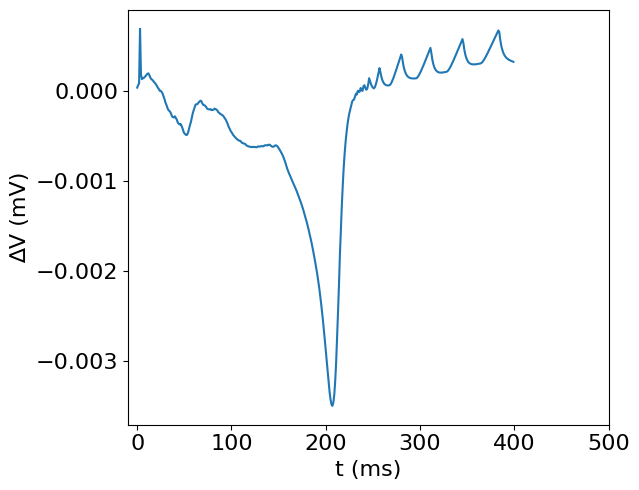

In [195]:
i=10 #max ∆V < 0.1mV
# i=9 #max ∆V < 0.1mV
a=V[:-1]
b=V_values[i::10]
diff_values=a[:400]-b[:400]
diff_values
#voltage
fontsize=16
save=True

plt.subplots(figsize=(6.5,5))
plt.plot(diff_values)
# plt.y_label
# plt.plot(t_values,V_values,c='k')
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.1,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.xlim([-10,500])
plt.ylabel('∆V (mV)', fontsize=fontsize)
# plt.xlim([-10,200])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='comp_check_LR_disagreement.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

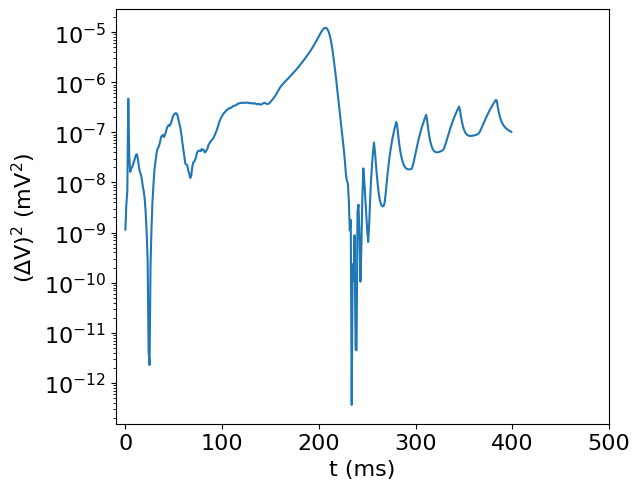

In [198]:
a=V[:-1]
b=V_values[i::10]
diff_values=a[:400]-b[:400]
diff_values
#voltage
fontsize=16
save=True

plt.subplots(figsize=(6.5,5))
plt.plot(diff_values**2)
# plt.y_label
# plt.plot(t_values,V_values,c='k')
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.1,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.xlim([-10,500])
plt.ylabel(r'(∆V)$^2$ (mV$^2$)', fontsize=fontsize)
# plt.xlim([-10,200])
plt.yscale('log')
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='comp_check_LR_disagreement.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

In [170]:
V_values[11::10][:10]

array([-74.84245205, -66.94782804, -58.90392799, -43.77503973,
        45.98377463,  39.87745416,  34.22142211,  29.11311938,
        24.53496463,  20.47517525])

The apparent disagreement may be the result of accumulated error resulting from floating point arithmetic.  Fortran handles this differently from Python, as memory serves.  This is an excitable system, after all.

Other potential causes: 
- is slow inward current computed the same?
- is initialization the same?
- is t+=dt also at the start?
- am i using the exact solution for the gating variables?

#Slow inward current
    #Difference Spotted between Esi and vca
    #Q: does this difference explain ∆V?
    #Q(if so): does this difference exist in what I used in generating the LR trajectories?
    #Esi=7.7-13.0287*np.log(Ca_i)#mV  vca=-82.3d0-13.0287d0*dlog(ca)
    Esi=-82.3-13.0287*np.log(Ca_i)#mV  vca=-82.3d0-13.0287d0*dlog(ca)
    Isi=Gsi*d*f*(V-Esi)        #xica=gca*xd*xf*(u-vca)
    #calcium uptake rate (dominated by activity of the sarcoplasmic reticulum)
    #Difference Spotted between Esi and vca
    #Q: does this difference explain ∆V?
    #Q(if so): does this difference exist in what I used in generating the LR trajectories?
    dCa_i_dt=-10**-4*Isi+0.07*(10**-4-Ca_i)  # cao=-1.d-7*xica +.07d0*(1.d-7-ca)
